# Identity

In [32]:
import PIL
from PIL import Image, ImageColor
import shutil
import pandas as pd
from IPython.display import Image, HTML
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Patch
from colorthief import ColorThief
import re
import numpy as np
from slugify import slugify
from wordcloud import WordCloud, STOPWORDS
import random

## Main Color of Top 5 Best Selling Albums Since 1990

### Define Functions

In [2]:
def str_formatter(x):
    x = re.sub('\t', '', x)
    x = re.sub('\n', '', x)
    return x

In [3]:
#Web scraping web archives (odd rows)
def archive_odd(index):
    global album, album_cover, img_url, album_artist, album_name, file_name
    album = soup.find_all('table', class_ = 'cbbTable_rowOn')[index]
        #Returns the gray rows in the table, odd rows
    album_cover = album.find_all(class_='cbbTable_c2')[0].find_all('img')[0].attrs['src']
        #Returns image link
    img_url = url_prefix + album_cover
        #Returns full image link
    album_artist = album.find_all('div', class_='cbbTable_text3')[0].text
        #Returns artist name
    album_artist = str_formatter(album_artist)
        #Returns artist name without formatting
    album_name = album.find_all('div', class_='cbbTable_text4')[0].text
        #Returns album name
    album_name = str_formatter(album_name)
        #Returns album name without formatting
    file_name = slugify(album_name)
        #Formats album names to usable file names
    save_image(img_url)
    colorthief(file_name)
    df_append(y)

In [4]:
#Web scraping web archives (even rows)
def archive_even(index):
    global album, album_cover, img_url, album_artist, album_name, file_name
    album = soup.find_all('table', class_ = 'cbbTable_rowOff')[index]
        #Returns the white rows in the table, even rows
    album_cover = album.find_all(class_='cbbTable_c2')[0].find_all('img')[0].attrs['src']
        #Returns image link
    img_url = url_prefix + album_cover
        #Returns full image link
    album_artist = str_formatter(album.find_all('div', class_='cbbTable_text3')[0].text)
        #Returns artist name
    album_name = str_formatter(album.find_all('div', class_='cbbTable_text4')[0].text)
        #Returns album name
    file_name = slugify(album_name)
        #Formats album names to usable file names
    save_image(img_url)
    colorthief(file_name)
    df_append(y)

In [5]:
#Web scraping current Billboards

def billboards(index):
    global album, album_cover, img_url, album_artist, album_name, file_name
    album = soup.find_all('div', class_ = 'o-chart-results-list-row-container')[index]
        #Returns each row
    img_url = album.find_all('li', class_ = 'o-chart-results-list__item')[1].find('img').attrs['data-lazy-src']
        #Returns image link
    album_artist = str_formatter(album.find_all('span')[1].text)
        #Returns artist name
    album_name = str_formatter(album.find('h3').text)
        #Returns album name
    file_name = slugify(album_name)
        #Formats album names to usable file names
    save_image(img_url)
    colorthief(file_name)
    df_append(y)

In [6]:
#Saves images
def save_image(img_url):
    r = requests.get(img_url, stream=True) #Get request on full_url
    if r.status_code == 200:                     #200 status code = OK
       with open(f"album covers/{file_name}.jpg", 'wb') as f: 
          r.raw.decode_content = True
          shutil.copyfileobj(r.raw, f)

https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image

In [7]:
#Convert rgb to hexcode
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

#Dominant color
def colorthief(album_name):
    global album_color
    color_thief = ColorThief(f'album covers/{album_name}.jpg')
    dominant_color = color_thief.get_color(quality=1)
    album_color = rgb_to_hex(dominant_color)

In [39]:
#Append to dataframe
def df_append(y):
    global df_albums
    df_row = [album_name, album_artist, year, y, f'<img src="album covers/{file_name}.jpg"/>', album_color, f'album covers/{file_name}.jpg']
    df = pd.DataFrame(df_row).transpose()
    df.columns = ['Album', 'Artist', 'Release Year', 'Rank', 'Cover', 'Color', 'File']
    df_albums = pd.concat([df_albums.loc[:], df]).reset_index(drop=True)

### Generates Dataframe of Top 5 Selling Albums 1990 - 2022

In [41]:
user_agent = {'User-agent': 'Mozilla/5.0'}
df_albums = pd.DataFrame(columns = ['Album', 'Artist', 'Release Year', 'Rank', 'Cover', 'Color', 'File'])

for year in range(1990, 2023):
    if year < 2002:
        url = f"https://web.archive.org/web/20071222015019/http://www.billboard.com/bbcom/charts/yearend_chart_display.jsp?f=The+Billboard+200&g=Year-end+Albums&year={year}"
        r = requests.get(url, headers = user_agent)
        soup = BeautifulSoup(r.text,"html.parser")
        url_prefix = 'https://web.archive.org'

        try:
            for y in np.array([1,2,3,4,5]):
                if y in np.array([1,3,5]):
                    index = int(y/2)
                    archive_odd(index)
                else:
                    index = int(y/2-1)
                    archive_even(index)
        except:
            pass
    else:
        url = f"https://www.billboard.com/charts/year-end/{year}/top-billboard-200-albums/"

        r = requests.get(url, headers = user_agent)
        soup = BeautifulSoup(r.text,"html.parser")

        for y in np.array([1,2,3,4,5]):
            index = int(y-1)
            billboards(index)

In [10]:
HTML(df_albums.to_html(escape=False))

,Album,Artist,Release Year,Rank,Cover,Color
0,Janet Jackson's Rhythm Nation 1814,Janet Jackson,1990,1,,#282628
1,...But Seriously,Phil Collins,1990,2,,#d6b37b
2,Soul Provider,Michael Bolton,1990,3,,#e0c8ae
3,Pump,Aerosmith,1990,4,,#e2dde1
4,Please Hammer Don't Hurt 'Em,M.C. Hammer,1990,5,,#d2b9bc
5,Mariah Carey,Mariah Carey,1991,1,,#362928
6,No Fences,Garth Brooks,1991,2,,#2e3231
7,Shake Your Money Maker,The Black Crowes,1991,3,,#28231e
8,Gonna Make You Sweat,C&C Music Factory,1991,4,,#eaece9
9,Wilson Phillips,Wilson Phillips,1991,5,,#947677


### Visualization

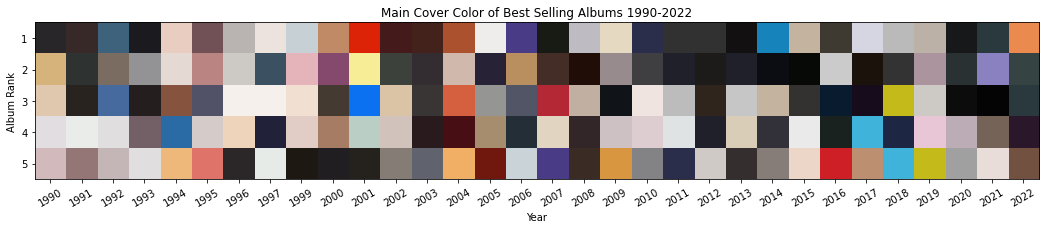

In [18]:
%matplotlib inline

plt.figure(figsize = (18,6))

color_list = list(df_albums.sort_values(by = ['Rank', 'Release Year'])['Color'])

plt.imshow(colors.to_rgba_array(color_list).reshape(5,32,4))
plt.xticks(ticks = range(0,32), labels = list(df_albums['Release Year'].unique()), rotation = 30)
plt.yticks(ticks = range(0,5), labels = [1, 2, 3, 4, 5])
plt.xlabel('Year')
plt.ylabel('Album Rank')
plt.title('Main Cover Color of Best Selling Albums 1990-2022')
plt.show()

## Main Color of Billboard's Best Albums of All Time

https://www.billboard.com/photos/best-album-covers-of-all-time-6715351

In [12]:
#Load in the CSV file created from the website

best_covers = pd.read_csv('best_album_covers.csv', encoding='cp1252')
best_covers.sort_values(by = 'Rank', inplace = True)
best_covers.reset_index(inplace = True, drop = True)

best_covers.head()

,Rank,Artist,Album,Year,Link
0,1,The Velvet Underground and Nico,The Velvet Underground & Nico,1967,https://www.billboard.com/wp-content/uploads/2...
1,2,The Beatles,Abbey Road,1969,https://www.billboard.com/wp-content/uploads/2...
2,3,Patti Smith,Horses,1975,https://www.billboard.com/wp-content/uploads/2...
3,4,The Notorious B.I.G.,Ready to Die,1994,https://www.billboard.com/wp-content/uploads/2...
4,5,Led Zeppelin,Led Zeppelin,1969,https://www.billboard.com/wp-content/uploads/2...


In [42]:
df_cover = pd.DataFrame(columns = ['Cover', 'Color', 'File'])

for x in range(1,51):
    global df_cover
    img_url = best_covers[best_covers['Rank'] == x]['Link'].iloc[0]
    file_name = f"Cover Rank {x}"
    save_image(img_url)
        #Open the URL to the cover and save into album covers folder
    
    colorthief(file_name)
        #Obtain dominant color of album cover
    
    df_row = [f'<img src="album covers/{file_name}.jpg"/>', album_color, f'album covers/{file_name}.jpg']
    df = pd.DataFrame(df_row).transpose()
    df.columns = ['Cover', 'Color', 'File']
    df_cover = pd.concat([df_cover.loc[:], df]).reset_index(drop=True)
        #Save into a dataframe

### Creating Dataframe

In [43]:
best_covers[['Cover', 'Color', 'File']] = df_cover
HTML(best_covers.to_html(escape=False))

,Rank,Artist,Album,Year,Link,Cover,Color,File
0,1,The Velvet Underground and Nico,The Velvet Underground & Nico,1967,https://www.billboard.com/wp-content/uploads/2022/03/1.-The-Velvet-Underground-and-Nico-%E2%80%98The-Velvet-Underground-Nico-1967-album-art-2022-billboard-1240.jpg?w=777,,#232014,album covers/Cover Rank 1.jpg
1,2,The Beatles,Abbey Road,1969,https://www.billboard.com/wp-content/uploads/2022/03/2.-The-Beatles-%E2%80%98Abbey-Road-1969-album-art-billboard-1240.jpg?w=768,,#2c3c3d,album covers/Cover Rank 2.jpg
2,3,Patti Smith,Horses,1975,https://www.billboard.com/wp-content/uploads/2022/03/3.-Patti-Smith-%E2%80%98Horses-1975-album-art-billboard-1240.jpg?w=855,,#c2bdba,album covers/Cover Rank 3.jpg
3,4,The Notorious B.I.G.,Ready to Die,1994,https://www.billboard.com/wp-content/uploads/2022/03/4.-The-Notorious-B.I.G.-%E2%80%98Ready-to-Die-1994-album-art-billboard-1240.jpg?w=799,,#fafaf8,album covers/Cover Rank 4.jpg
4,5,Led Zeppelin,Led Zeppelin,1969,https://www.billboard.com/wp-content/uploads/2022/03/5.-Led-Zeppelin-%E2%80%98Led-Zeppelin-1969-album-art-billboard-1240.jpg?w=768,,#f1ebdc,album covers/Cover Rank 5.jpg
5,6,Pink Floyd,Dark Side of the Moon,1973,https://www.billboard.com/wp-content/uploads/2022/03/6.-Pink-Floyd-%E2%80%98Dark-Side-of-the-Moon-1973-album-art-billboard-1240.jpg?w=768,,#040404,album covers/Cover Rank 6.jpg
6,7,Nirvana,Nevermind,1991,https://www.billboard.com/wp-content/uploads/2022/03/7.-Nirvana-%E2%80%98Nevermind-1991-album-art-billboard-1240.jpg?w=768,,#0f7bae,album covers/Cover Rank 7.jpg
7,8,Cyndi Lauper,She's So Unusual,1983,https://www.billboard.com/wp-content/uploads/2022/03/8.-Cyndi-Lauper-%E2%80%98Shes-So-Unusual-1983-album-art-billboard-1240.jpg?w=768,,#c49387,album covers/Cover Rank 8.jpg
8,9,Public Enemy,Fear of a Black Planet,1990,https://www.billboard.com/wp-content/uploads/2022/03/9.-Public-Enemy-%E2%80%98Fear-of-a-Black-Planet-1990-album-art-2022-billboard-1240.jpg?w=768,,#1c2944,album covers/Cover Rank 9.jpg
9,10,Elvis Presley,Elvis Presley,1956,https://www.billboard.com/wp-content/uploads/2022/03/10.-Elvis-Presley-%E2%80%98Elvis-Presley-1956-album-art-billboard-1240.jpg?w=855,,#1e1f1f,album covers/Cover Rank 10.jpg


### Creating Visualization

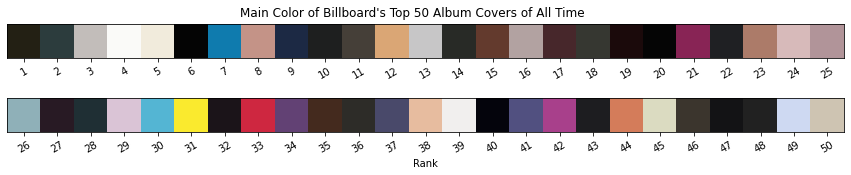

In [25]:
%matplotlib inline

plt.figure(figsize = (15,2.5))

color_list = list(best_covers['Color'])

plt.subplot(2, 1, 1)
plt.imshow(colors.to_rgba_array(color_list[0:25]).reshape(1,25,4))
plt.tick_params(left = False, labelleft = False)
plt.xticks(ticks = range(0,25), labels = list(range(1,26)), rotation = 30)

plt.subplot(2, 1, 2)
plt.imshow(colors.to_rgba_array(color_list[25:51]).reshape(1,25,4))
plt.tick_params(left = False, labelleft = False)
plt.xticks(ticks = range(0,25), labels = list(range(26,51)), rotation = 30)
plt.xlabel('Rank')

plt.suptitle('Main Color of Billboard\'s Top 50 Album Covers of All Time', y = 0.9)
plt.show()

## Spotify Hit vs Miss Songs Dataset (2010s)
https://www.kaggle.com/datasets/theoverman/the-spotify-hit-predictor-dataset/code

Column definitions from https://developer.spotify.com/documentation/web-api/reference/get-audio-features

In [17]:
spotify_df = pd.read_csv('dataset-of-10s.csv')
spotify_df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1


In [18]:
#Adding a labeled categorical column for Target aka Hit or Miss

conditions = [
    (spotify_df['target'] == 0),
    (spotify_df['target'] == 1)
]

values = ['Miss', 'Hit']

spotify_df['Success'] = np.select(conditions, values)

In [19]:
spotify_df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,Success
0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,1,Hit
1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,0,Miss
2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,1,Hit
3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,0,Miss
4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,1,Hit


### Exploratory Data Analysis

In [187]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6398 entries, 0 to 6397
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             6398 non-null   object 
 1   artist            6398 non-null   object 
 2   uri               6398 non-null   object 
 3   danceability      6398 non-null   float64
 4   energy            6398 non-null   float64
 5   key               6398 non-null   int64  
 6   loudness          6398 non-null   float64
 7   mode              6398 non-null   int64  
 8   speechiness       6398 non-null   float64
 9   acousticness      6398 non-null   float64
 10  instrumentalness  6398 non-null   float64
 11  liveness          6398 non-null   float64
 12  valence           6398 non-null   float64
 13  tempo             6398 non-null   float64
 14  duration_ms       6398 non-null   int64  
 15  time_signature    6398 non-null   int64  
 16  chorus_hit        6398 non-null   float64


In [188]:
spotify_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
count,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6398.000000,6.398000e+03,6398.000000,6398.000000,6398.000000,6398.000000
mean,0.568163,0.667756,5.283526,-7.589796,0.645514,0.098018,0.216928,0.165293,0.196700,0.443734,122.353871,2.367042e+05,3.930916,41.028399,10.316505,0.500000
std,0.191103,0.240721,3.606216,5.234592,0.478395,0.097224,0.296835,0.318736,0.166148,0.245776,29.847389,8.563698e+04,0.377469,19.568827,3.776011,0.500039
min,0.062200,0.000251,0.000000,-46.655000,0.000000,0.022500,0.000000,0.000000,0.016700,0.000000,39.369000,2.985300e+04,0.000000,0.000000,2.000000,0.000000
25%,0.447000,0.533000,2.000000,-8.425000,0.000000,0.038825,0.008533,0.000000,0.096800,0.240000,98.091250,1.932068e+05,4.000000,28.059135,8.000000,0.000000
50%,0.588000,0.712500,5.000000,-6.096500,1.000000,0.057200,0.067050,0.000017,0.126000,0.434000,121.070000,2.212465e+05,4.000000,36.265365,10.000000,0.500000
75%,0.710000,0.857000,8.000000,-4.601250,1.000000,0.112000,0.311000,0.057650,0.249000,0.628000,141.085000,2.593165e+05,4.000000,48.292538,12.000000,1.000000
max,0.981000,0.999000,11.000000,-0.149000,1.000000,0.956000,0.996000,0.995000,0.982000,0.976000,210.977000,1.734201e+06,5.000000,213.154990,88.000000,1.000000


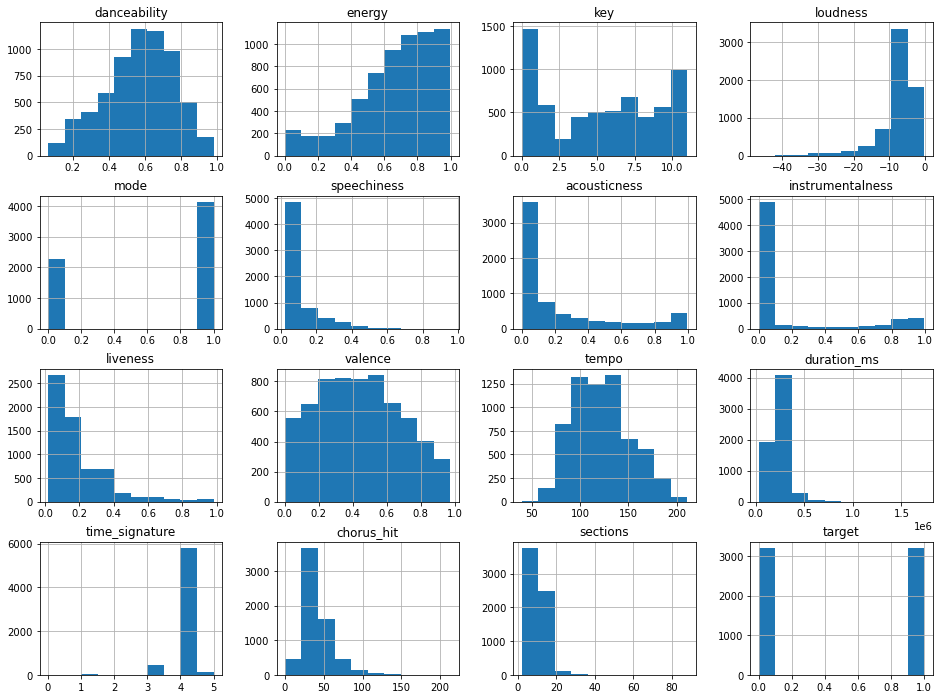

In [189]:
%matplotlib inline

fig = spotify_df.hist(figsize = (16,12))

<AxesSubplot:>

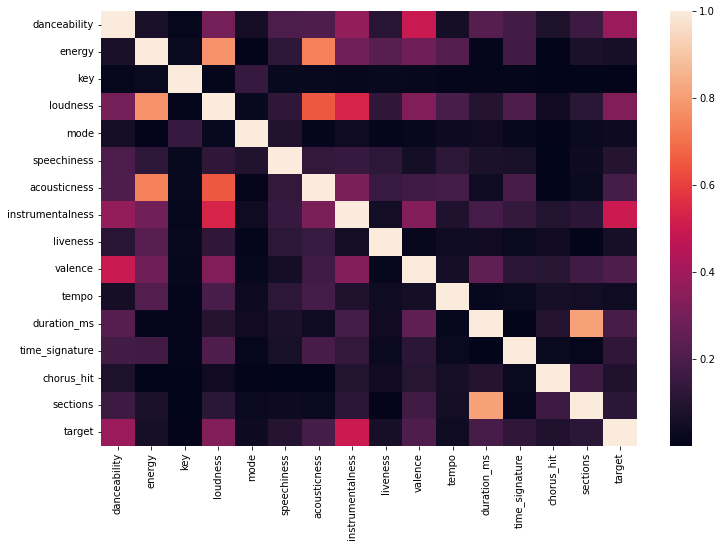

In [179]:
corr = spotify_df.corr(method = 'pearson')
plt.figure(figsize = (12,8))
sns.heatmap(corr.abs())

<AxesSubplot:xlabel='Success', ylabel='duration_ms'>

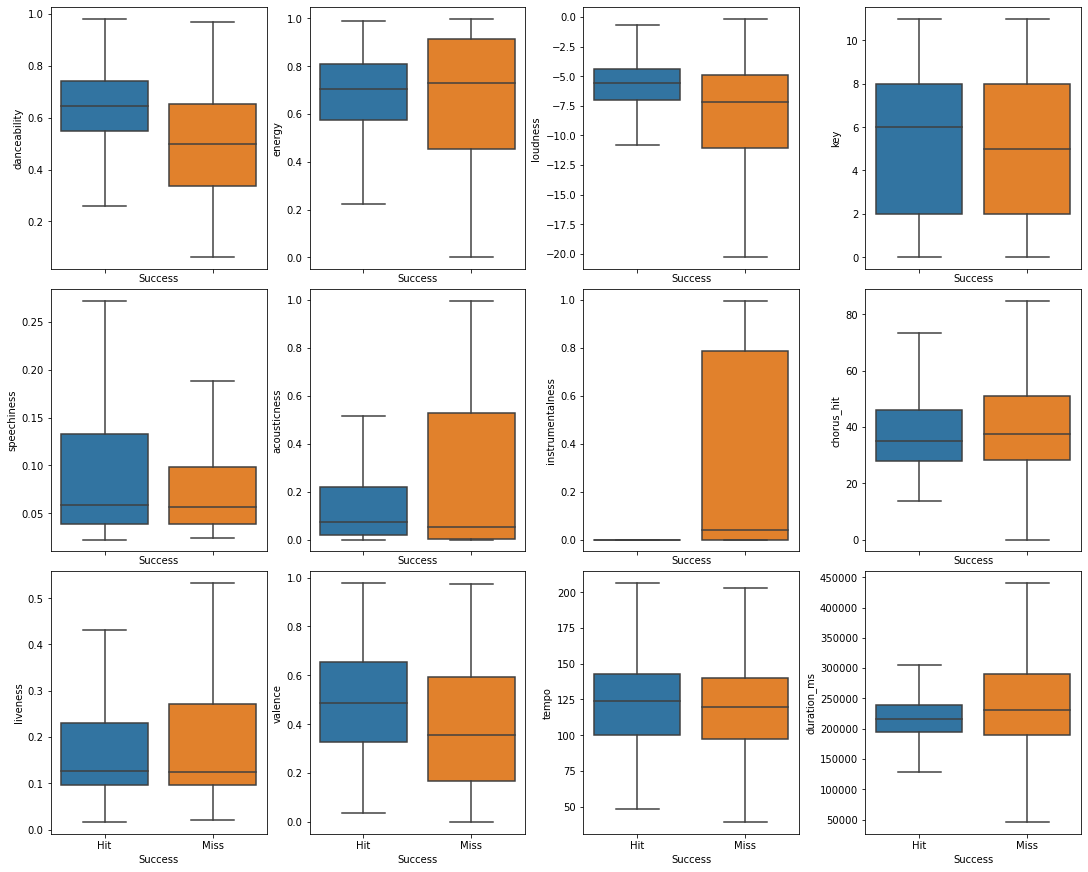

In [199]:
%matplotlib inline

fig, axes = plt.subplots(3,4, sharex = True, figsize = (15,12), constrained_layout=True)
sns.boxplot(ax = axes[0,0], data = spotify_df, x = 'Success', y = 'danceability', showfliers = False)
sns.boxplot(ax = axes[0,1], data = spotify_df, x = 'Success', y = 'energy', showfliers = False)
sns.boxplot(ax = axes[0,2], data = spotify_df, x = 'Success', y = 'loudness', showfliers = False)
sns.boxplot(ax = axes[0,3], data = spotify_df, x = 'Success', y = 'key', showfliers = False)
sns.boxplot(ax = axes[1,0], data = spotify_df, x = 'Success', y = 'speechiness', showfliers = False)
sns.boxplot(ax = axes[1,1], data = spotify_df, x = 'Success', y = 'acousticness', showfliers = False)
sns.boxplot(ax = axes[1,2], data = spotify_df, x = 'Success', y = 'instrumentalness', showfliers = False)
sns.boxplot(ax = axes[1,3], data = spotify_df, x = 'Success', y = 'chorus_hit', showfliers = False)
sns.boxplot(ax = axes[2,0], data = spotify_df, x = 'Success', y = 'liveness', showfliers = False)
sns.boxplot(ax = axes[2,1], data = spotify_df, x = 'Success', y = 'valence', showfliers = False)
sns.boxplot(ax = axes[2,2], data = spotify_df, x = 'Success', y = 'tempo', showfliers = False)
sns.boxplot(ax = axes[2,3], data = spotify_df, x = 'Success', y = 'duration_ms', showfliers = False)

In [246]:
#Converting ms to minutes for easier interpretation

spotify_df['Duration (mins)'] = spotify_df['duration_ms']/60000

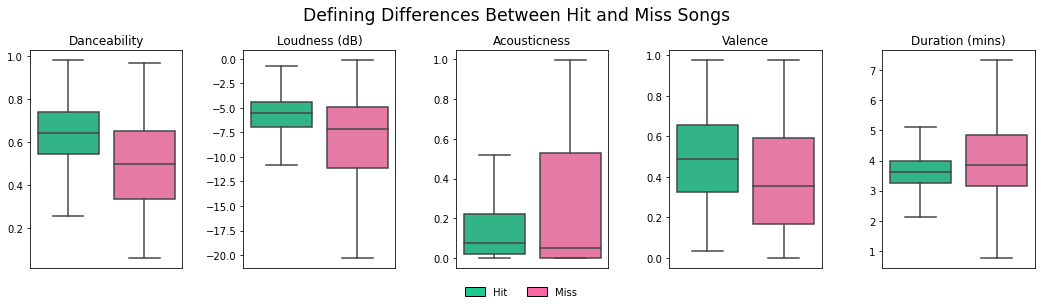

In [296]:
%matplotlib inline

#Setting chosen theme color palette for this visualization
sns.set_palette(sns.color_palette(['#1EC98D','#f768a1']))

fig, axes = plt.subplots(1,5, figsize = (18,4))
plt.subplots_adjust(wspace=0.4, hspace=0.3)
sns.boxplot(ax = axes[0], data = spotify_df, x = 'Success', y = 'danceability', showfliers = False).set(title = 'Danceability')
sns.boxplot(ax = axes[1], data = spotify_df, x = 'Success', y = 'loudness', showfliers = False).set(title = 'Loudness (dB)')
sns.boxplot(ax = axes[2], data = spotify_df, x = 'Success', y = 'acousticness', showfliers = False).set(title = 'Acousticness')
#sns.boxplot(ax = axes[1,0], data = spotify_df, x = 'Success', y = 'instrumentalness', showfliers = False).set(ylabel = 'Instrumentalness')
sns.boxplot(ax = axes[3], data = spotify_df, x = 'Success', y = 'valence', showfliers = False).set(title = 'Valence')
sns.boxplot(ax = axes[4], data = spotify_df, x = 'Success', y = 'Duration (mins)', showfliers = False).set(title = 'Duration (mins)')

plt.suptitle('Defining Differences Between Hit and Miss Songs', verticalalignment = 'bottom', y = 0.97, fontsize = 'xx-large')

patch_hit = Patch(color = '#1EC98D', label = 'Hit', ec = 'black')
patch_miss = Patch(color = '#f768a1', label = 'Miss', ec = 'black')

plt.figlegend(handles = [patch_hit, patch_miss], loc = 'lower center', handleheight = 1, frameon = False, ncol = 2)

for ax in axes:
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.show()

## Lyrics Analysis

Using the Genius.com API
https://lyricsgenius.readthedocs.io/en/master/index.html

### Text Cleansing Functions

In [120]:
def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def remove_punctuation_space(text: str) -> str:
    return re.sub('[^a-zA-Z|\s]', '', str(text))

def replace_line_break(text: str) -> str:
    return re.sub('\n', ' ', str(text))

def remove_symbols(text: str) -> str:
    return re.sub('[(\'"-,.?!)]', '', str(text))

def clean_text(text: str) -> str:
    text = replace_line_break(text)
    text = remove_punctuation_space(text)
    text = remove_tags(text)
    text = remove_symbols(text)
    return text

### Sampling

In [20]:
#Sampling 100 hit songs 

hits = spotify_df[spotify_df['target']==1][['track', 'artist']].sample(n=100, random_state = 44)
hits.head()

,track,artist
5135,Rollin,Calvin Harris Featuring Future & Khalid
905,Southern Comfort Zone,Brad Paisley
3639,Knockin' Boots,Luke Bryan
1354,Love Me Anyway,P!nk Featuring Chris Stapleton
5515,Cash Shit,Megan Thee Stallion Featuring DaBaby


In [21]:
#Removing features for better searching 

hits['main artist'] = hits['artist'].str.split(' Featuring').str[0]

hits['lyrics'] = '' #adding empty column for lyrics later

hits.head()

,track,artist,main artist,lyrics
5135,Rollin,Calvin Harris Featuring Future & Khalid,Calvin Harris,
905,Southern Comfort Zone,Brad Paisley,Brad Paisley,
3639,Knockin' Boots,Luke Bryan,Luke Bryan,
1354,Love Me Anyway,P!nk Featuring Chris Stapleton,P!nk,
5515,Cash Shit,Megan Thee Stallion Featuring DaBaby,Megan Thee Stallion,


### Setting up API

In [22]:
#pip install lyricsgenius

from lyricsgenius import Genius

token = '2N2g5mQnfOduTA74y4VkVAGAOkz-quq-F5wdJ-hfrxjKg2W1Rpqjz9k2WAI-cjZW'

genius = Genius(token, timeout = 200, verbose = False, remove_section_headers = True)

### Generating DataFrame

In [166]:
hits.reset_index(drop = True, inplace = True)

In [167]:
#Generating lyric search

for i in range(0, len(hits)):
    songs = genius.search_songs(hits.loc[i,'track'] +' '+ hits.loc[i,'main artist'])
    hits.loc[i,'lyrics'] = genius.lyrics(song_url = songs['hits'][0]['result']['url'])

In [168]:
hits.head()

,track,artist,main artist,lyrics,length,cleaned_lyrics,lemmas
0,Rollin,Calvin Harris Featuring Future & Khalid,Calvin Harris,99 ContributorsRollin Lyrics\nI've been rollin...,3071,NaN,
1,Southern Comfort Zone,Brad Paisley,Brad Paisley,9 ContributorsSouthern Comfort Zone Lyrics\nYo...,1770,NaN,
2,Knockin' Boots,Luke Bryan,Luke Bryan,14 ContributorsKnockin’ Boots Lyrics\nThis tru...,1708,NaN,
3,Love Me Anyway,P!nk Featuring Chris Stapleton,P!nk,27 ContributorsLove Me Anyway Lyrics\nEven if ...,1213,NaN,
4,Cash Shit,Megan Thee Stallion Featuring DaBaby,Megan Thee Stallion,45 ContributorsCash Shit Lyrics\nReal hot girl...,3734,NaN,


(array([ 2.,  3., 21., 26., 21., 11.,  4.,  8.,  1.,  3.]),
 array([ 195. ,  665.7, 1136.4, 1607.1, 2077.8, 2548.5, 3019.2, 3489.9,
        3960.6, 4431.3, 4902. ]),
 <BarContainer object of 10 artists>)

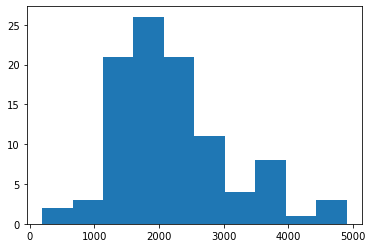

In [169]:
#Checking to make sure all the data loaded in properly

hits['length'] = hits['lyrics'].str.len()
plt.hist(hits['length'])

In [170]:
#Some songs look suspiciously short

hits[hits['length'] < 1000]

,track,artist,main artist,lyrics,length,cleaned_lyrics,lemmas
8,Either Way,Chris Stapleton,Chris Stapleton,17 ContributorsEither Way Lyrics\nWe pass in t...,957,NaN,
15,Prayer In C,Lillywood & Robin Schulz,Lillywood & Robin Schulz,"1 ContributorSong Covers Lyrics""Heart-Shaped B...",195,NaN,
98,Harlem Shake,Baauer,Baauer,34 ContributorsHarlem Shake Lyrics\nCon los te...,652,NaN,


In [171]:
#Prayer C is not correct

hits.loc[15, 'lyrics']

'1 ContributorSong Covers Lyrics"Heart-Shaped Box" - Nirvana\n"Prayer In A C" -  Lilly Wood and Robin Schulzs\n"Nobody To Love" - Sigma / "Doo Wop (That Thing)" - Lauryn HillYou might also likeEmbed'

In [38]:
#Finding the correct version

songs = genius.search_songs('Prayer in C')
genius.lyrics(song_url = songs['hits'][0]['result']['url'])

"39 ContributorsPrayer in C (Robin Schulz Radio Edit) Lyrics\nYeah, you never said a word\nYou didn't send me no letter\nDon't think I could forgive you\nSee, our world is slowly dying\nI'm not wasting no more time\nDon't think I could believe you\nYeah, you never said a word\nYou didn't send me no letter\nDon't think I could forgive you\nSee, our world is slowly dying\nI'm not wasting no more time\nDon't think I could believe you\n\nYeah, our hands will get more wrinkled\nAnd our hair will be grey\nDon't think I could forgive you\nAnd see, the children are starving\nAnd their houses were destroyed\nDon't think they could forgive you\nHey, when seas will cover lands\nAnd when man will be no more\nDon't think you can forgive you\nYeah, when there'll just be silence\nAnd when life will be over\nDon't think you will forgive you\nYou might also like\nYeah, you never said a word\nYou didn't send me no letter\nDon't think I could forgive you\nSee, our world is slowly dying\nI'm not wasting n

In [172]:
#Prayer C is not correct

hits.loc[15, 'lyrics'] = genius.lyrics(song_url = songs['hits'][0]['result']['url'])

hits['length'] = hits['lyrics'].str.len()
    #Recalculating length

### Cleaning the Data

In [173]:
#Removing the header

hits['cleaned_lyrics'] = hits['lyrics'].str.split('Lyrics\n').str[1]

In [174]:
#Removing the word Embed at the end
hits['cleaned_lyrics'] = hits['cleaned_lyrics'].str.split('Embed').str[0]

In [176]:
hits.head()

,track,artist,main artist,lyrics,length,cleaned_lyrics,lemmas
0,Rollin,Calvin Harris Featuring Future & Khalid,Calvin Harris,99 ContributorsRollin Lyrics\nI've been rollin...,3071,I've been rollin' on the freeway\nI've been ri...,
1,Southern Comfort Zone,Brad Paisley,Brad Paisley,9 ContributorsSouthern Comfort Zone Lyrics\nYo...,1770,You might be a redneck ...\n(radio static)\nTh...,
2,Knockin' Boots,Luke Bryan,Luke Bryan,14 ContributorsKnockin’ Boots Lyrics\nThis tru...,1708,This truck needs a half tank\nThese wheels nee...,
3,Love Me Anyway,P!nk Featuring Chris Stapleton,P!nk,27 ContributorsLove Me Anyway Lyrics\nEven if ...,1213,"Even if you see my scars, even if I break your...",
4,Cash Shit,Megan Thee Stallion Featuring DaBaby,Megan Thee Stallion,45 ContributorsCash Shit Lyrics\nReal hot girl...,3734,"Real hot girl shit\nYeah, I'm in my bag, but I...",


In [177]:
hits['cleaned_lyrics'] = hits['cleaned_lyrics'].str.lower()

for i in range(0, len(hits)):
    hits.loc[i, 'cleaned_lyrics'] = clean_text(hits.loc[i,'cleaned_lyrics'])

In [239]:
#Creating a text string of all the lyrics
text = ''
for i in range(0, len(hits)):
    lyrics = hits.loc[i, 'cleaned_lyrics']
    text = lyrics + ' ' + text

### WordCloud

In [216]:
col_diverging = ['#7a0177','#c51b8a','#f768a1','#fa9fb5','#fcc5c0','#feebe2', '#edf8fb','#ccece6','#99d8c9','#66c2a4','#2ca25f','#006d2c']

(0, 109, 44)

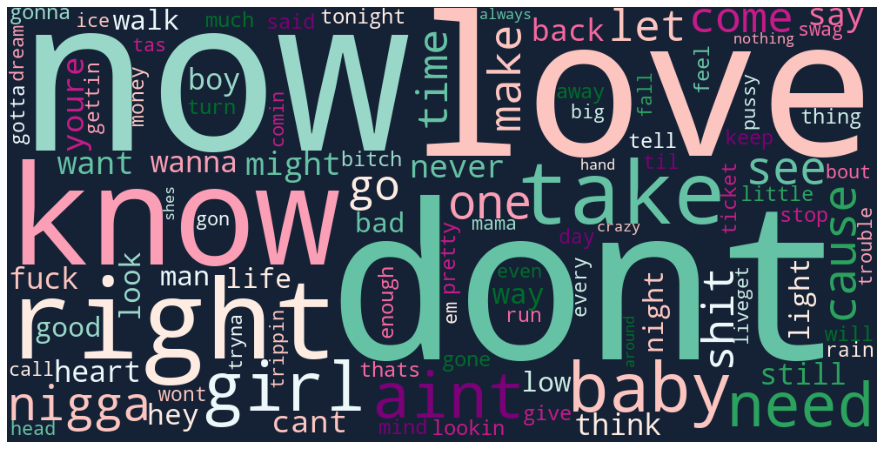

In [240]:
%matplotlib inline

def color(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=44, **kwargs):
    return ImageColor.getcolor(col_diverging[random.randint(0,len(col_diverging)-1)], 'RGB')


stopwords = set(STOPWORDS)
stopwords.add('yeah')
stopwords.add('im')
stopwords.add('ive')
stopwords.add('ill')
stopwords.add('oh')
stopwords.add('ayy')
stopwords.add('ooh')
stopwords.add('uh')
stopwords.add('woah')
stopwords.add('er')
stopwords.add('got')

wordcloud = WordCloud(width = 1000, height = 500, max_words = 100, background_color = '#152235',
                      color_func =  color, stopwords = stopwords, normalize_plurals = True, collocations = False).generate(text)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Diversification
The group member who completed these visualizations did all of his work in R. Please see the R code for more indepth data analysis and cleansing. The final datasets were exported out of R and into Python to ensure consistent formatting. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
from matplotlib.patches import Patch
from colorthief import ColorThief
import numpy as np

### Soundtrack Influence

In [10]:
sd_df = pd.read_csv('Soundtrack_Influence.csv')
sd_df

,Artist,Category,Value
0,Lady Gaga,Content Catalog,8
1,Lady Gaga,Total Streams,27
2,Lady Gaga,Daily Streams,24
3,Justin Timberlake,Content Catalog,17
4,Justin Timberlake,Total Streams,19
5,Justin Timberlake,Daily Streams,16
6,Daft Punk,Content Catalog,11
7,Daft Punk,Total Streams,5
8,Daft Punk,Daily Streams,3
9,Arcade Fire,Content Catalog,13


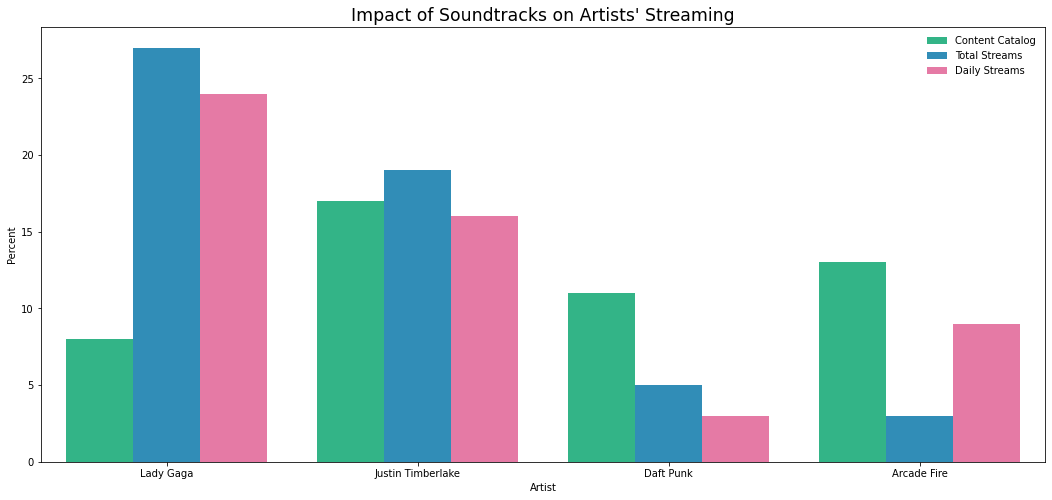

In [11]:
%matplotlib inline

#Setting chosen theme color palette for this visualization
sns.set_palette(sns.color_palette(['#1EC98D','#1B96CD','#f768a1']))

plt.figure(figsize = (18,8))

ax = sns.barplot(data = sd_df, x = 'Artist', y = 'Value', hue ='Category')
plt.ylabel('Percent')
plt.title('Impact of Soundtracks on Artists\' Streaming', fontsize = 'xx-large')
plt.legend(loc = 'upper right', framealpha = 0)
plt.savefig('SoundtrackImpact.png', transparent = True,bbox_inches='tight')
plt.show()

### Soundtrack Case Study

In [2]:
gaga_df = pd.read_csv('LG_Hits.csv', index_col = 0)
gaga_df.reset_index(inplace = True, drop = True)
gaga_df.head()

,Song_Title,Streams,Daily,Album,Type
0,Marry The Night,103395432,42720,Born This Way,Non-Soundtrack Song
1,John Wayne,103511575,24697,Joanne,Non-Soundtrack Song
2,G.U.Y.,109165629,53964,Artpop,Non-Soundtrack Song
3,Music To My ESoundtrack Song,118694250,19425,A Star Is Born Soundtrack,Soundtrack Song
4,Is That Alright?,128555597,43752,A Star Is Born Soundtrack,Soundtrack Song


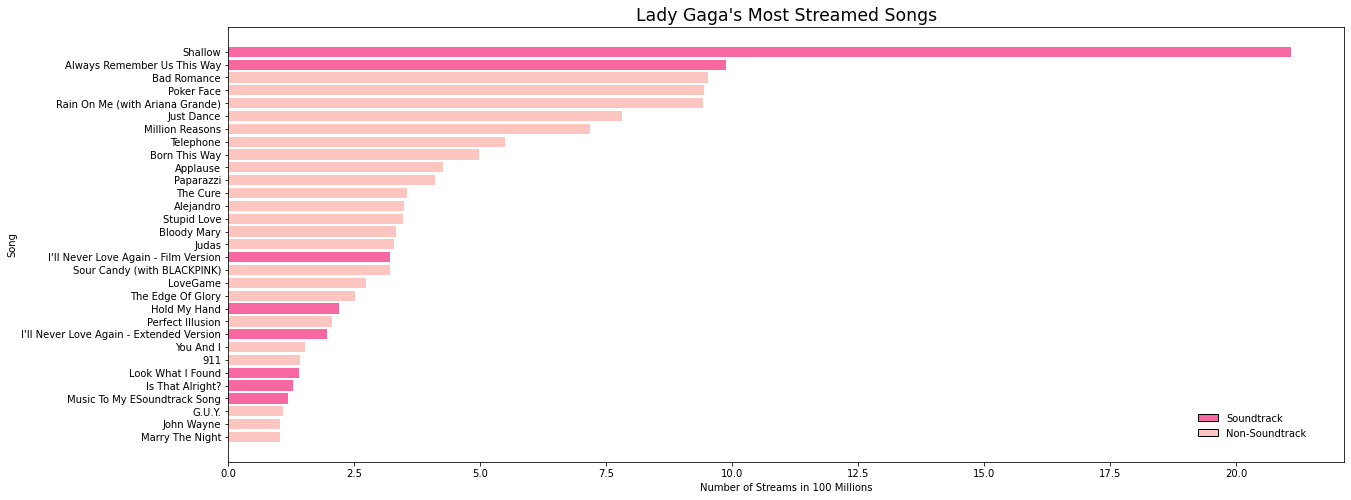

In [3]:
%matplotlib inline

#filter to songs > 100m streams
gaga_hits = gaga_df[gaga_df['Streams'] > 1e8]
gaga_hits['Streams (Millions)'] = gaga_hits['Streams']/1e8

hue = {'Non-Soundtrack Song': '#fcc5c0', 'Soundtrack Song': '#f768a1'}

plt.figure(figsize = (20,8))

plt.barh(y = gaga_hits['Song_Title'], width = gaga_hits['Streams (Millions)'], color = [hue[i] for i in gaga_hits['Type']])

patch1 = Patch(color = '#f768a1', label = 'Soundtrack', ec = 'black')
patch2 = Patch(color = '#fcc5c0', label = 'Non-Soundtrack', ec = 'black')

plt.figlegend(handles = [patch1, patch2], loc = 'lower right', bbox_to_anchor = (0.88, 0.15), framealpha = 0)

plt.xlabel('Number of Streams in 100 Millions')
plt.ylabel('Song')
plt.title('Lady Gaga\'s Most Streamed Songs', fontsize = 'xx-large')

#plt.savefig('Soundtrack_LadyGaga.png', transparent = True,bbox_inches='tight')
plt.show()

### Other Media Case Studies

In [12]:
HS_search = pd.read_csv('HS_TimeSeries.csv', parse_dates = ['Month'])
HS_search.head()

,Month,Interest
0,2010-01-01,>1
1,2010-02-01,>2
2,2010-03-01,>3
3,2010-04-01,>4
4,2010-05-01,>5


In [13]:
#Removing non int rows
HS_search = HS_search[HS_search['Interest'].str.contains('>')==False].copy()
HS_search['Interest'] = HS_search['Interest'].astype(int)
HS_search.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 8 to 160
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Month     153 non-null    datetime64[ns]
 1   Interest  153 non-null    int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 3.0 KB


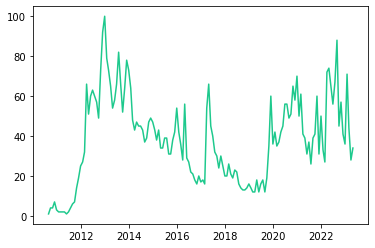

In [14]:
plt.plot(HS_search['Month'], HS_search['Interest'])

In [15]:
HS_df = pd.read_csv('ArtistActor_Export.csv', parse_dates = ['Release_Date'])
HS_df = HS_df[HS_df['Artist'] == 'Harry Styles']
HS_df.info()
HS_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 11 to 34
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Artist         24 non-null     object        
 1   Movie          24 non-null     object        
 2   Google_Search  21 non-null     object        
 3   Release_Date   24 non-null     datetime64[ns]
 4   Media          24 non-null     object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.1+ KB


,Artist,Movie,Google_Search,Release_Date,Media
11,Harry Styles,Harry Styles: Satellite,release+date+Harry+Styles:+Satellite,1905-07-14,Music Video
12,Harry Styles,Harry Styles: Music for a Sushi Restaurant,release+date+Harry+Styles:+Music+for+a+Sushi+R...,1905-07-14,Music Video
13,Harry Styles,My Policeman,release+date+My+Policeman,2022-10-21,Film
14,Harry Styles,Don't Worry Darling,release+date+Don't+Worry+Darling,2022-09-23,Film
15,Harry Styles,Harry Styles: Late Night Talking,release+date+Harry+Styles:+Late+Night+Talking,1905-07-14,Music Video


In [16]:
#Removing bad data

HS_df = HS_df[HS_df['Release_Date'] >= HS_search['Month'].min()]
HS_df

,Artist,Movie,Google_Search,Release_Date,Media
13,Harry Styles,My Policeman,release+date+My+Policeman,2022-10-21,Film
14,Harry Styles,Don't Worry Darling,release+date+Don't+Worry+Darling,2022-09-23,Film
18,Harry Styles,Eternals,release+date+Eternals,2021-11-05,Film
20,Harry Styles,Ouverture of Something that Never Ended,NaN,2020-11-18,TV
26,Harry Styles,Gucci: Men's Tailoring Campaign,release+date+Gucci:+Men's+Tailoring+Campaign,2019-05-21,Ad
27,Harry Styles,Met Gala: Camp! Teaser,release+date+Met+Gala:+Camp!+Teaser,2019-04-19,Ad
30,Harry Styles,Harry Styles: Nova's Red Room Secret Gig,release+date+Harry+Styles:+Nova's+Red+Room+Sec...,2017-09-08,Music Video
31,Harry Styles,Dunkirk,release+date+Dunkirk,2017-07-21,Film
33,Harry Styles,One Direct: That Moment,NaN,2014-04-02,Film
34,Harry Styles,iCarly,NaN,2012-04-07,TV


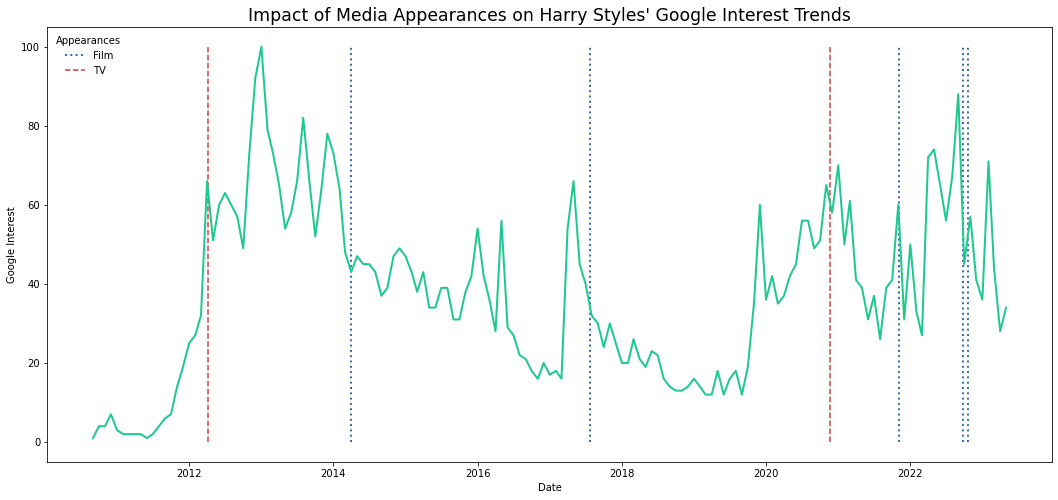

In [17]:
%matplotlib inline

plt.figure(figsize = (18,8))
plt.plot(HS_search['Month'], HS_search['Interest'], color = '#1EC98D', linewidth = 2)
plt.vlines(x = HS_df[HS_df['Media'] == 'Film']['Release_Date'], ymin = 0, ymax = 100, color = '#386cb0', linestyles ='dotted', linewidth = 2, label = 'Film')
plt.vlines(x = HS_df[HS_df['Media'] == 'TV']['Release_Date'], ymin = 0, ymax = 100, color = '#D14343', linestyles ='dashed', label = 'TV')

plt.legend(loc = 'upper left', title = 'Appearances', frameon = False)

plt.xlabel('Date')
plt.ylabel('Google Interest')
plt.title('Impact of Media Appearances on Harry Styles\' Google Interest Trends', fontsize = 'xx-large')

#plt.savefig('HarryStylesInterest.png', transparent = True,bbox_inches='tight')
plt.show()